In [ ]:
pip install lightgbm

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import preprocessing
import numpy as np
import lightgbm as lgb
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
data= pd.read_csv("0.DatosS_Renovacion_prestamo.csv",sep=";")

In [3]:
data.head()

,MES,CLIENTE,LINEA_RENOVADO,PLAZO_RENOVADO,FLAG_VENTA,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,...,PConsumo_Sldo_Bco_T1,SDO_BCO_tot_sm_pasivo_Bco_6M,EDAD,SEXO,EST_CIVIL,ANTIGUEDAD_MES,REGION,FLAG_LIMA_PROVINCIA,SUELDO_ESTIMADO,CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD
0,201506,1,3770,12,0,0.000000,0.000000,1,-1,271.12,...,457,3754.333333,25.0,M,S,23.0,LIMA NORTE,1,3531.0,0.071915
1,201506,2,1300,6,0,0.000000,0.000000,1,0,11200.00,...,11200,1581.333333,33.0,M,S,56.0,LIMA ESTE,1,1322.0,8.615380
2,201506,3,7800,36,0,0.429507,0.225615,5,-2,20156.45,...,4778,10241.000000,26.0,M,S,20.0,LIMA MODERNA,1,4234.0,2.584160
3,201506,4,6630,12,0,0.000000,0.000000,1,1,20485.14,...,0,5797.333333,51.0,M,S,166.0,NORTE,0,6647.0,3.089760
4,201506,5,15497,36,1,NaN,NaN,1,0,1682.83,...,1935,16755.333330,35.0,M,C,55.0,NORTE,0,2094.0,0.108590


## Identificando el target

In [4]:
data["FLAG_VENTA"].value_counts(normalize=True)

0    0.960117
1    0.039883
Name: FLAG_VENTA, dtype: float64

* Vemos que la cantidad de cliente con venta es el 3.9883 % y sin venta es 96.0117 %.
* Podemos observar que el target está desbalanceado.

In [5]:
data.shape

(87556, 22)

Vemos que la cantidad de filas es 87556 y de columnas 22 

## 1.-Analisis Explotarorio
* valores missing
* valores ouliters
* graficos
* correlacion 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87556 entries, 0 to 87555
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MES                                 87556 non-null  int64  
 1   CLIENTE                             87556 non-null  int64  
 2   LINEA_RENOVADO                      87556 non-null  int64  
 3   PLAZO_RENOVADO                      87556 non-null  int64  
 4   FLAG_VENTA                          87556 non-null  int64  
 5   USO_LINEA_TOTAL_TC_T2               68364 non-null  float64
 6   USO_TRIM_LINEA_BBVA                 68364 non-null  float64
 7   NR_ENTIDADES_TOTAL_T2               87556 non-null  int64  
 8   DIFF_NRO_ENTIDA_TOTALES_T2_T12      87556 non-null  int64  
 9   SDO_CONSUMO_T2                      82370 non-null  float64
 10  RESENCIA_OFERTA_PLD_RENOVADO        73700 non-null  float64
 11  Ahorro_Sldo_Bco_T1                  87556

In [7]:
data["CLIENTE"].value_counts()

2047     1
23198    1
6806     1
4759     1
27288    1
        ..
23905    1
17762    1
19811    1
30052    1
2049     1
Name: CLIENTE, Length: 87556, dtype: int64

Vemos que los clientes son únicos

In [8]:
features=[col for col in data.columns if col not in ["CLIENTE","FLAG_VENTA"]]
features

['MES',
 'LINEA_RENOVADO',
 'PLAZO_RENOVADO',
 'USO_LINEA_TOTAL_TC_T2',
 'USO_TRIM_LINEA_BBVA',
 'NR_ENTIDADES_TOTAL_T2',
 'DIFF_NRO_ENTIDA_TOTALES_T2_T12',
 'SDO_CONSUMO_T2',
 'RESENCIA_OFERTA_PLD_RENOVADO',
 'Ahorro_Sldo_Bco_T1',
 'PConsumo_Sldo_Bco_T1',
 'SDO_BCO_tot_sm_pasivo_Bco_6M',
 'EDAD',
 'SEXO',
 'EST_CIVIL',
 'ANTIGUEDAD_MES',
 'REGION',
 'FLAG_LIMA_PROVINCIA',
 'SUELDO_ESTIMADO',
 'CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD']

Creamos una lista de features donde estarán las variables a considerar para el modelo y excluímos:
* CLIENTE       : Por ser una variable única, si ningún sigfinicado para el modelo
* FLAG_VENTA    : Por ser la variable objetivo.

In [9]:
data.head()

,MES,CLIENTE,LINEA_RENOVADO,PLAZO_RENOVADO,FLAG_VENTA,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,...,PConsumo_Sldo_Bco_T1,SDO_BCO_tot_sm_pasivo_Bco_6M,EDAD,SEXO,EST_CIVIL,ANTIGUEDAD_MES,REGION,FLAG_LIMA_PROVINCIA,SUELDO_ESTIMADO,CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD
0,201506,1,3770,12,0,0.000000,0.000000,1,-1,271.12,...,457,3754.333333,25.0,M,S,23.0,LIMA NORTE,1,3531.0,0.071915
1,201506,2,1300,6,0,0.000000,0.000000,1,0,11200.00,...,11200,1581.333333,33.0,M,S,56.0,LIMA ESTE,1,1322.0,8.615380
2,201506,3,7800,36,0,0.429507,0.225615,5,-2,20156.45,...,4778,10241.000000,26.0,M,S,20.0,LIMA MODERNA,1,4234.0,2.584160
3,201506,4,6630,12,0,0.000000,0.000000,1,1,20485.14,...,0,5797.333333,51.0,M,S,166.0,NORTE,0,6647.0,3.089760
4,201506,5,15497,36,1,NaN,NaN,1,0,1682.83,...,1935,16755.333330,35.0,M,C,55.0,NORTE,0,2094.0,0.108590


In [10]:
def total_missing(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percent=(data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    tt=pd.concat([total,percent],axis=1,keys=["Total Nulls","percent"])
    types=[]
    for  col in data.columns:
        dtype=str(data[col].dtype)
        types.append(dtype)
    tt["Types"]=types
    return (tt)
total_missing(data)

,Total Nulls,percent,Types
USO_TRIM_LINEA_BBVA,19192,21.919686,int64
USO_LINEA_TOTAL_TC_T2,19192,21.919686,int64
RESENCIA_OFERTA_PLD_RENOVADO,13856,15.825300,int64
SDO_CONSUMO_T2,5186,5.923066,int64
SUELDO_ESTIMADO,37,0.042259,int64
REGION,18,0.020558,float64
ANTIGUEDAD_MES,1,0.001142,float64
EST_CIVIL,1,0.001142,int64
SEXO,1,0.001142,int64
EDAD,1,0.001142,float64


Análizamos el porcentaje de missing por variables y la variable que tiene(n) nulo(s) es(son):
* "USO_LINEA_TOTAL_TC_T2 " 
* "USO_TRIM_LINEA_BBVA" 
* "SDO_CONSUMO_T2"
* "RESENCIA_OFERTA_PLD_RENOVADO " 
* "EDAD" 
* "SEXO" 
* "EST_CIVIL" 
* "ANTIGUEDAD_MES" 
* "REGION" 
* "SUELDO_ESTIMADO"
* "CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"
*  Posteriormente se hará una imputación con la mediana ya que es una variable numérica

In [11]:
cat_features=[col for col in data.columns if data[col].dtypes==np.object and col not in  ["CLIENTE","FLAG_VENTA"]]
cat_features.append("FLAG_LIMA_PROVINCIA")
cat_features.append("MES")
data["FLAG_LIMA_PROVINCIA"].unique()

array([1, 0], dtype=int64)

Creamos la lista "cat_features" donde estarán todas las variables categóricas.
Añadimos las variables tipo object y también la variables "FLAG_LIMA_PROVINCIA" que es tipo numérico pero con solo 2 valores( 1 y 0 )

In [12]:
data.loc[:,"RESENCIA_OFERTA_PLD_RENOVADO"]=data["RESENCIA_OFERTA_PLD_RENOVADO"].fillna(0) 

Se asume que los valores nulos es por que solo tiene una oferta, por ello cambiamos los nulos por "0" meses transcuridos.

In [13]:
data[cat_features].head(5)

,SEXO,EST_CIVIL,REGION,FLAG_LIMA_PROVINCIA,MES
0,M,S,LIMA NORTE,1,201506
1,M,S,LIMA ESTE,1,201506
2,M,S,LIMA MODERNA,1,201506
3,M,S,NORTE,0,201506
4,M,C,NORTE,0,201506


## Analisis de variables categoricas nóminales y ordinales


Text(0, 0.5, 'Proporción de Venta')

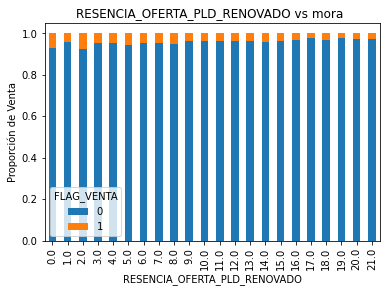

In [14]:
table=pd.crosstab(data["RESENCIA_OFERTA_PLD_RENOVADO"],data["FLAG_VENTA"] )
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("RESENCIA_OFERTA_PLD_RENOVADO vs mora ")
plt.xlabel("RESENCIA_OFERTA_PLD_RENOVADO")
plt.ylabel("Proporción de Venta")

Vemos que mientras aumentan los meses transcurridos desde la primera oferta hay menos probabilidad de una venta

Text(0, 0.5, 'Proporción de Venta')

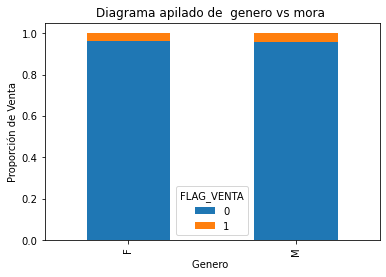

In [15]:
table=pd.crosstab(data["SEXO"],data["FLAG_VENTA"] )
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  genero vs mora ")
plt.xlabel("Genero ")
plt.ylabel("Proporción de Venta")

* En el gráfico de genero se observa que los hombres y mujeres tiene probabilidad de venta similares.

Text(0, 0.5, 'Proporción de Venta')

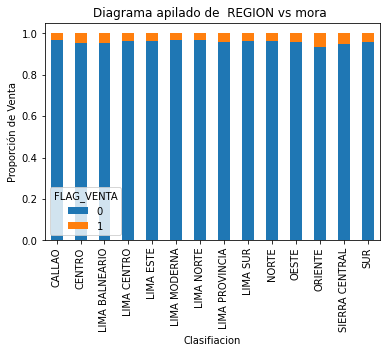

In [16]:
table=pd.crosstab(data["REGION"],data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  REGION vs mora ")
plt.xlabel("Clasifiacion")
plt.ylabel("Proporción de Venta")

* Vemos que la personas de la región Oriente tienen mayor probabilidad de venta.

Text(0, 0.5, 'Proporción de Venta')

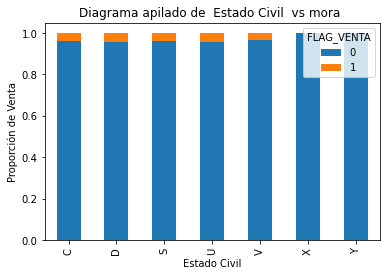

In [17]:

table=pd.crosstab(data["EST_CIVIL"],data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  Estado Civil  vs mora ")
plt.xlabel("Estado Civil")
plt.ylabel("Proporción de Venta")

* En el grafico de nivel de Estado Civil se observa que las personas "X" e "Y" un 100% de posibilidad de no tener venta y las  demás categorías tiene probabilidad similar de tener ventas.

Text(0, 0.5, 'Proporción de Venta')

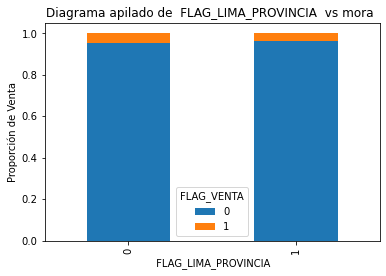

In [18]:
table=pd.crosstab(data["FLAG_LIMA_PROVINCIA"],data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  FLAG_LIMA_PROVINCIA  vs mora ")
plt.xlabel(" FLAG_LIMA_PROVINCIA")
plt.ylabel("Proporción de Venta")

* En el grafico de FLAG_LIMA_PROVINCIA vemos que la variable en sus dos categoría tiene similar comportamiento, no obstante las categoría "1" tiene ligeramente más probabilidad de venta.

Text(0, 0.5, 'Proporción de Venta')

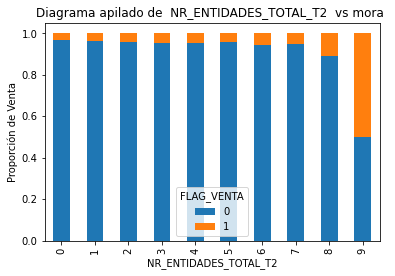

In [19]:
table=pd.crosstab(data["NR_ENTIDADES_TOTAL_T2"],data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  NR_ENTIDADES_TOTAL_T2  vs mora ")
plt.xlabel("NR_ENTIDADES_TOTAL_T2")
plt.ylabel("Proporción de Venta")

Mientras más entidad financiera esta afiliado el cliente, tiene mayor probabilidad de venta

Text(0, 0.5, 'Proporción de Venta')

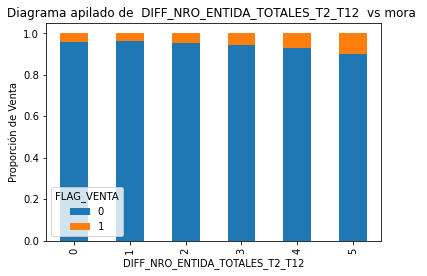

In [20]:
data["DIFF_NRO_ENTIDA_TOTALES_T2_T12"]=abs(data["DIFF_NRO_ENTIDA_TOTALES_T2_T12"])
table=pd.crosstab(data["DIFF_NRO_ENTIDA_TOTALES_T2_T12"],data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  DIFF_NRO_ENTIDA_TOTALES_T2_T12  vs mora ")
plt.xlabel("DIFF_NRO_ENTIDA_TOTALES_T2_T12")
plt.ylabel("Proporción de Venta")

A mayor magnitud mayor probabilidad de venta

Vemos que los meses tiene probabilidades similares de venta por lo cual no aportaría mucha información.

Text(0, 0.5, 'Proporción de Venta')

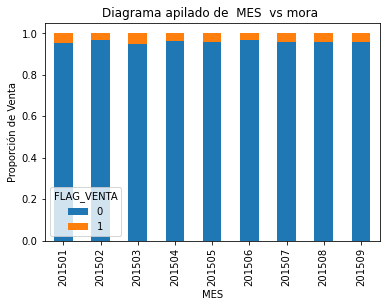

In [21]:
table=pd.crosstab(abs(data["MES"]),data["FLAG_VENTA"])
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de  MES  vs mora ")
plt.xlabel("MES")
plt.ylabel("Proporción de Venta")

In [22]:
numerical_features=[col for col in data.columns if col not in cat_features+["CLIENTE","FLAG_VENTA","MES"]]
numerical_features

['LINEA_RENOVADO',
 'PLAZO_RENOVADO',
 'USO_LINEA_TOTAL_TC_T2',
 'USO_TRIM_LINEA_BBVA',
 'NR_ENTIDADES_TOTAL_T2',
 'DIFF_NRO_ENTIDA_TOTALES_T2_T12',
 'SDO_CONSUMO_T2',
 'RESENCIA_OFERTA_PLD_RENOVADO',
 'Ahorro_Sldo_Bco_T1',
 'PConsumo_Sldo_Bco_T1',
 'SDO_BCO_tot_sm_pasivo_Bco_6M',
 'EDAD',
 'ANTIGUEDAD_MES',
 'SUELDO_ESTIMADO',
 'CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD']

Creando una lista "numerical_features" donde estarán todas las variables númericas 

In [23]:
data[numerical_features].describe()

,LINEA_RENOVADO,PLAZO_RENOVADO,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,RESENCIA_OFERTA_PLD_RENOVADO,Ahorro_Sldo_Bco_T1,PConsumo_Sldo_Bco_T1,SDO_BCO_tot_sm_pasivo_Bco_6M,EDAD,ANTIGUEDAD_MES,SUELDO_ESTIMADO,CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD
count,87556.000000,87556.000000,68364.000000,68364.000000,87556.000000,87556.00000,82370.000000,87556.000000,8.755600e+04,8.755600e+04,8.755600e+04,87555.000000,87555.000000,87519.000000,87556.000000
mean,20938.425511,32.364327,0.128593,0.096935,1.906049,0.62930,14385.172299,12.377438,1.080555e+04,1.967329e+04,2.874608e+04,43.820753,124.336508,4766.287255,0.737811
std,19528.059348,10.976920,0.192200,0.204709,1.185088,0.75629,21570.062428,7.641714,7.068362e+04,3.503195e+04,1.225501e+05,10.822434,74.882609,6003.919849,1.038843
min,700.000000,6.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-9.790000e+02,-9.800000e+01,-1.123800e+03,21.000000,3.000000,0.000000,0.000000
25%,9100.000000,24.000000,0.000000,0.000000,1.000000,0.00000,4102.655000,6.000000,1.470000e+02,3.954000e+03,1.002792e+03,35.000000,59.000000,2183.490000,0.326458
50%,14300.000000,36.000000,0.030634,0.000000,2.000000,0.00000,8368.145000,15.000000,1.208000e+03,1.016200e+04,6.363167e+03,43.000000,106.000000,3178.120000,0.548123
75%,25350.000000,36.000000,0.191262,0.069125,3.000000,1.00000,15786.390000,20.000000,5.246000e+03,2.145300e+04,2.371033e+04,52.000000,189.000000,5599.000000,0.775066
max,100000.000000,60.000000,1.466976,1.666666,9.000000,5.00000,722781.090000,21.000000,8.597760e+06,2.132740e+06,9.077797e+06,72.000000,561.000000,240909.000000,52.434200


Visualizamos los indicadores estadísticos de las variables numéricas

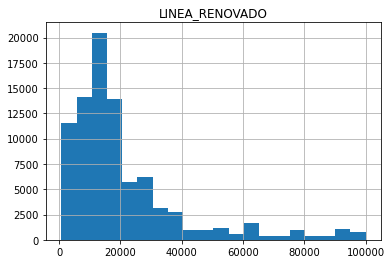

None


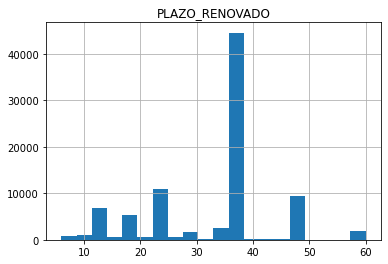

None


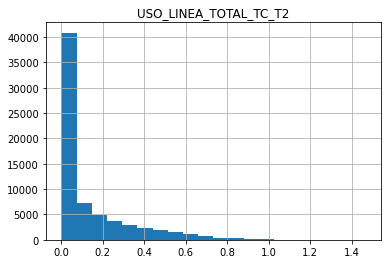

None


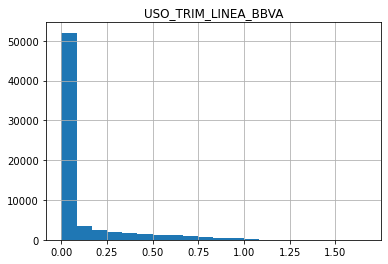

None


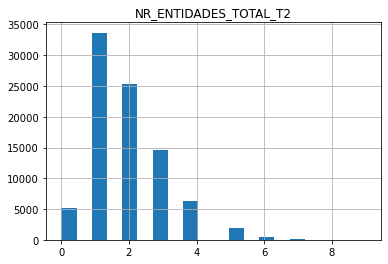

None


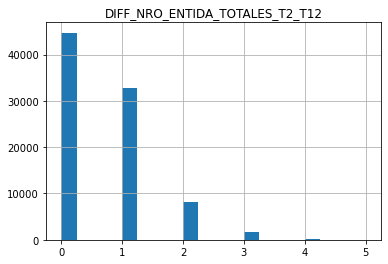

None


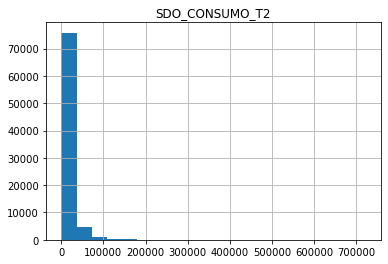

None


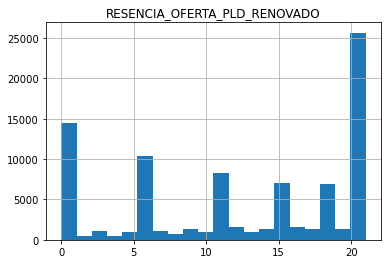

None


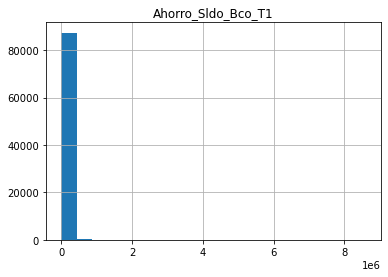

None


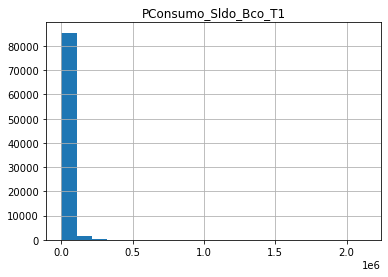

None


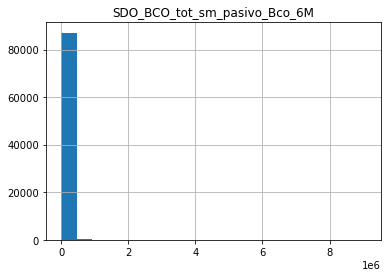

None


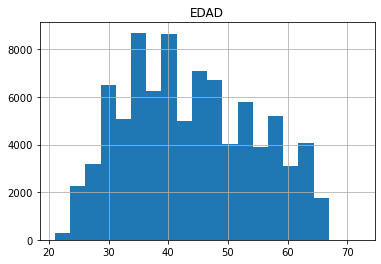

None


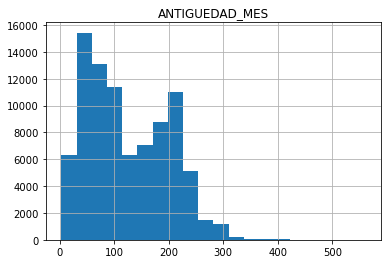

None


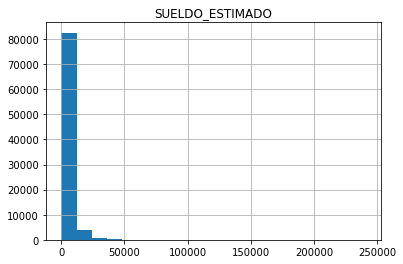

None


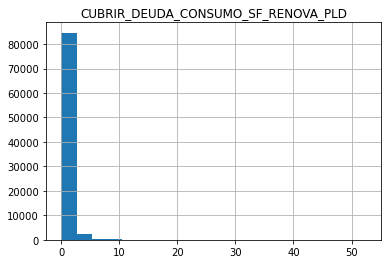

None


In [24]:
def hist_graph(df,col):
    df=df.copy()
    df[col].hist(bins=20)
    plt.title(col)
    plt.show()
for col in numerical_features:
    print(hist_graph(data,col))

* Gráficando histogramas de las variables numéricas para ver su distribución.
* En el grafico de histograma que puede observar que las variables tienen una distribucion mas asimentrica se podria aplicar una transformacion logaritmica que ayude a que se vuelva simetrica

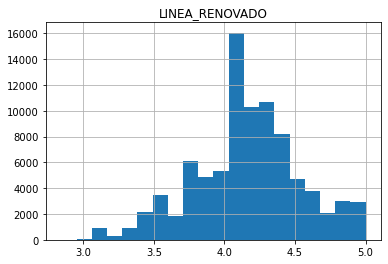

None


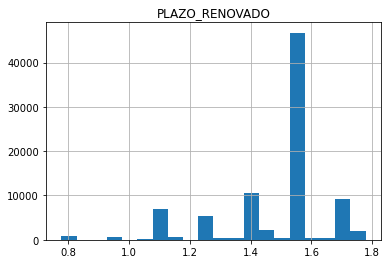

None
None
None
None
None
None
None
None
None
None


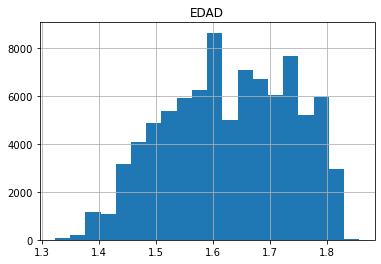

None


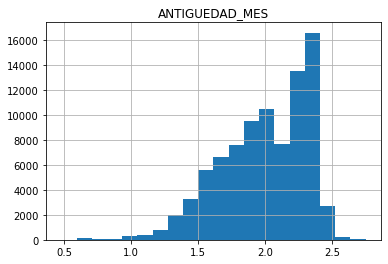

None
None
None


In [25]:
def hist_graph_log(df,col):
    df=df.copy()
    if any(data[col] <= 0):
        pass
    else:
        df[col]=np.log10(df[col]).hist(bins=20)
        plt.title(col)
        plt.show()
for col in numerical_features:
    print(hist_graph_log(data,col))

In [26]:
data.loc[:,["LINEA_RENOVADO","ANTIGUEDAD_MES"]]=np.log10(data.loc[:,["LINEA_RENOVADO","ANTIGUEDAD_MES"]])

* Usando la transformacion logaritmica ,vemos que ayudo a las variables ["LINEA_RENOVADO","ANTIGUEDAD_MES"] a mejorar su simetería.

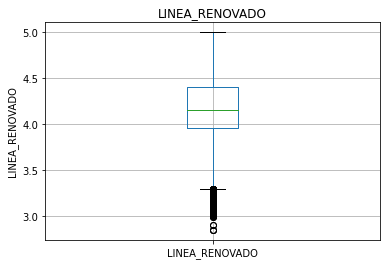

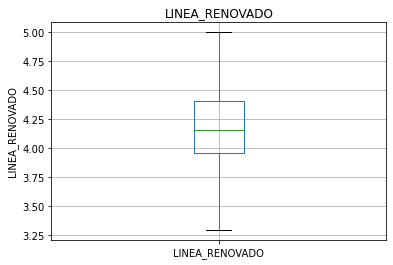

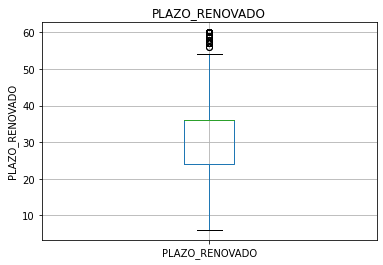

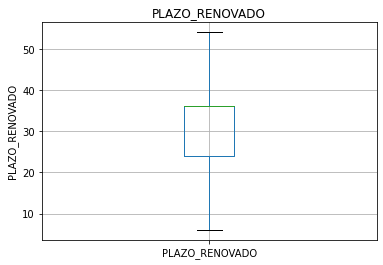

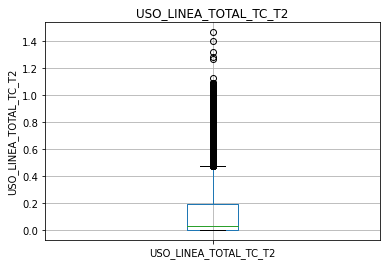

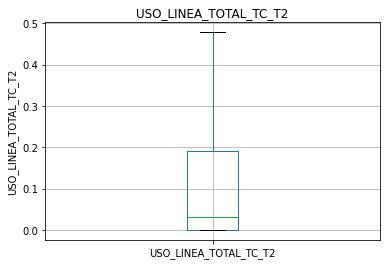

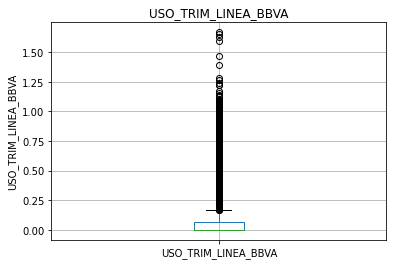

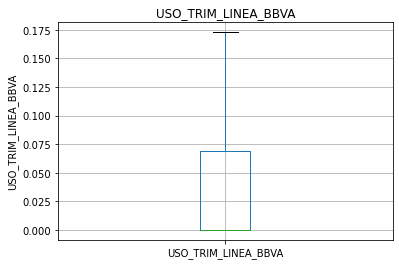

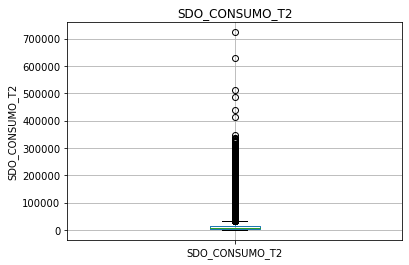

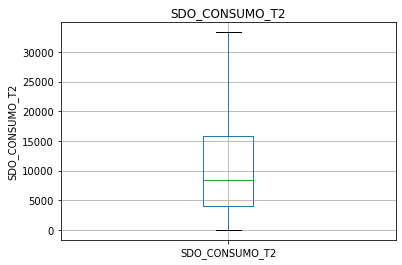

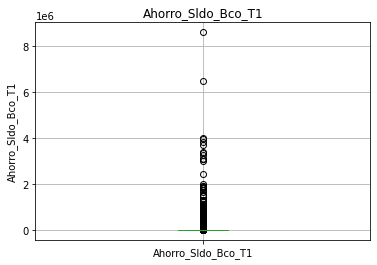

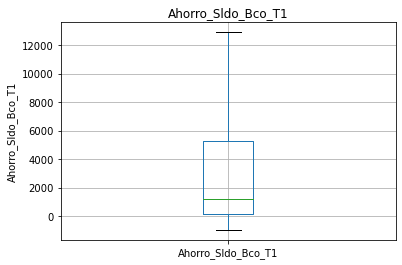

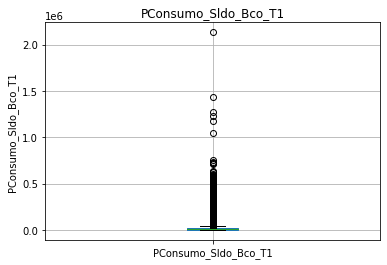

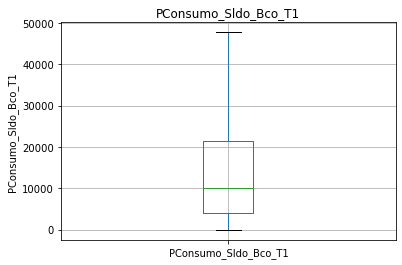

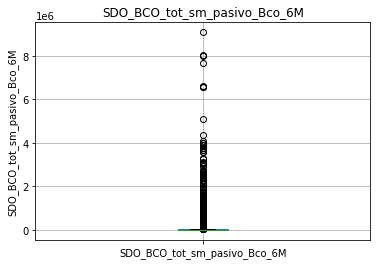

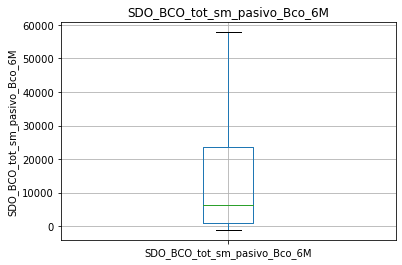

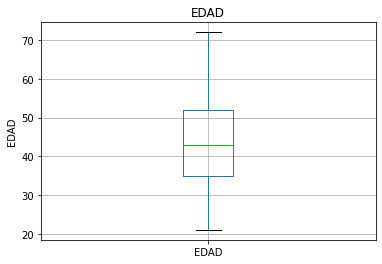

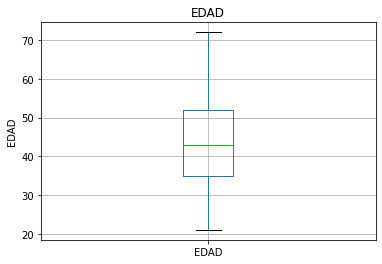

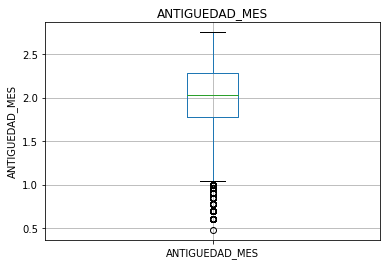

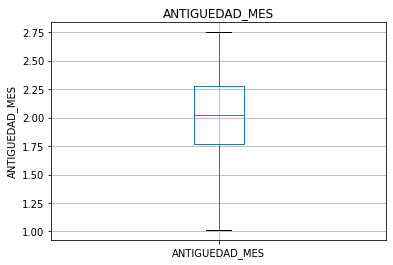

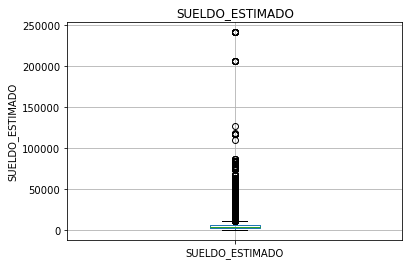

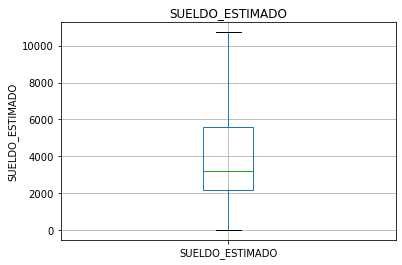

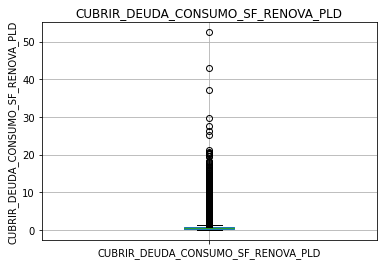

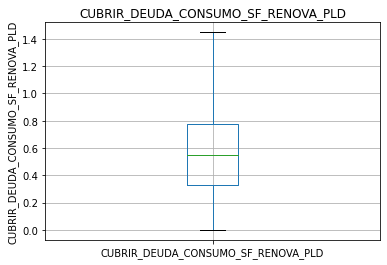

In [27]:
def find_outliers(df, var):
    df = df.copy()
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()



for var in numerical_features:
    if((var!="NR_ENTIDADES_TOTAL_T2") and (var!="DIFF_NRO_ENTIDA_TOTALES_T2_T12")and (var!="RESENCIA_OFERTA_PLD_RENOVADO")):
        find_outliers(data, var)
        q1 = data[var].quantile(0.25)
        q3 = data[var].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        m = np.mean(data[var])
        for i in data[var]:
            if i > Upper_tail :
                data[var] = data[var].replace(i, Upper_tail)
            elif i < Lower_tail:
                data[var] = data[var].replace(i, Lower_tail)
        find_outliers(data, var)    
    

* En grafico de cajas se puede observar la presencia de valores atipicos
* Vemos muchos valores atípicos

In [28]:
import seaborn as sns

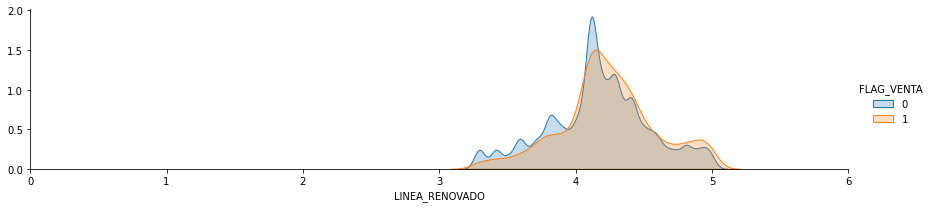

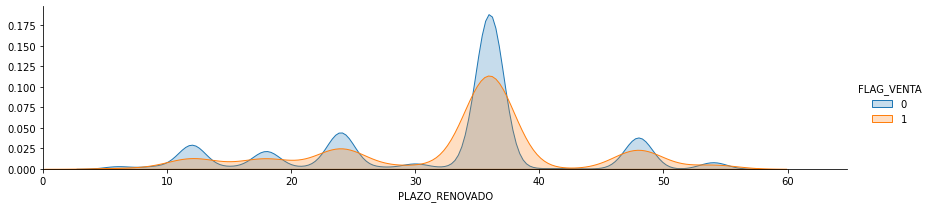

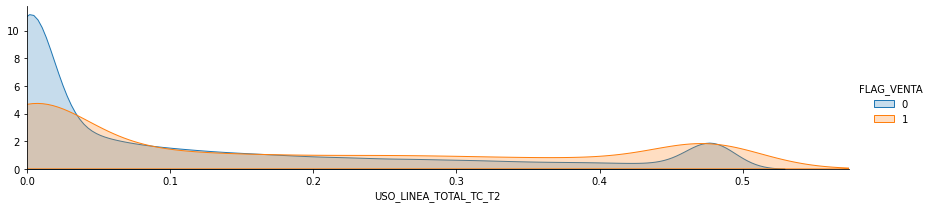

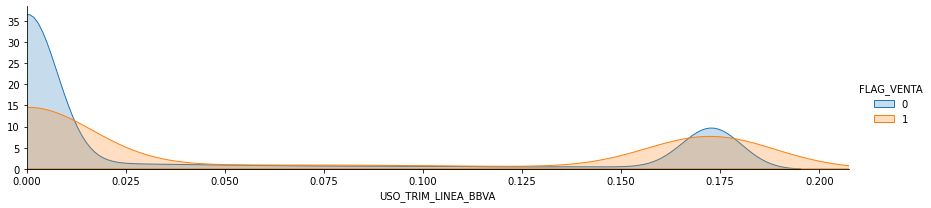

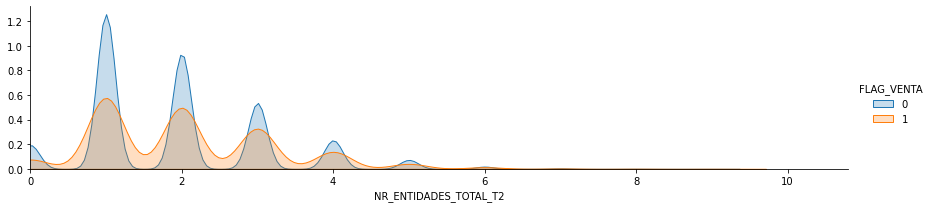

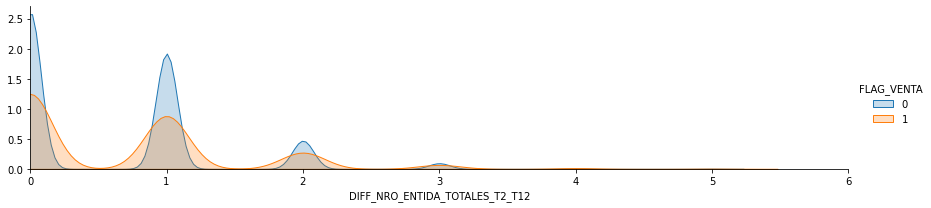

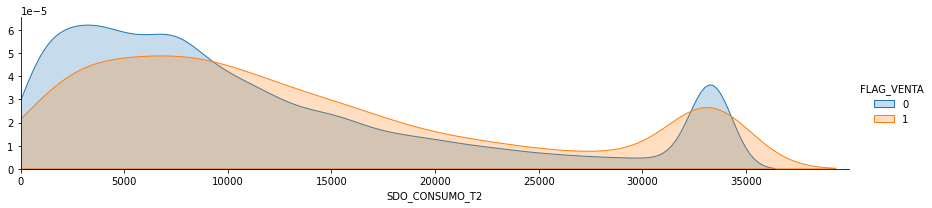

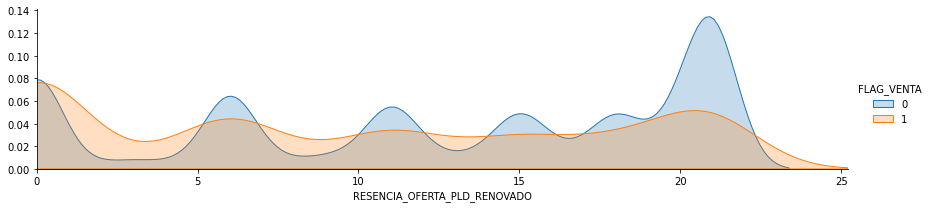

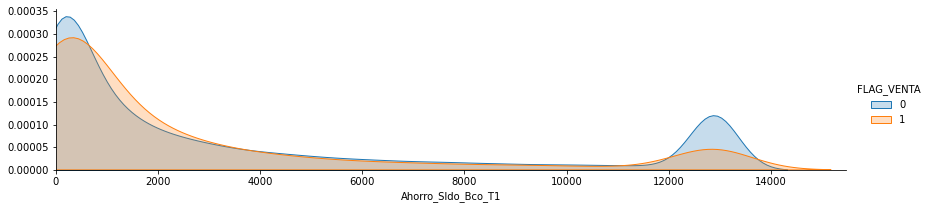

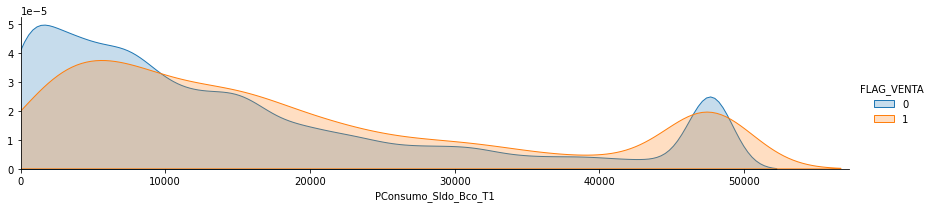

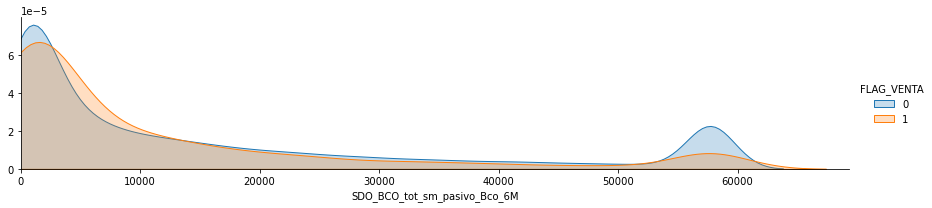

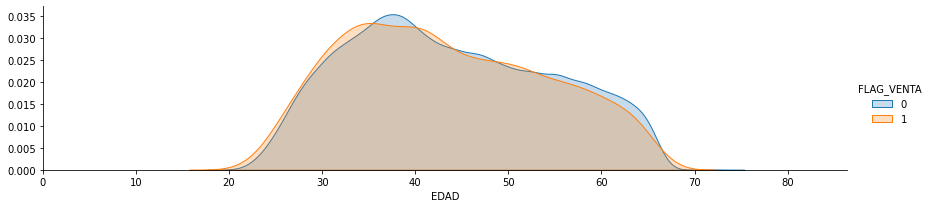

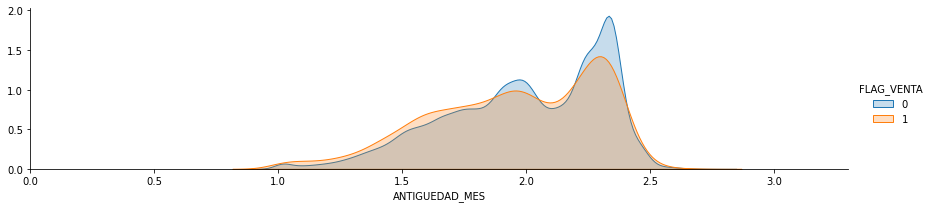

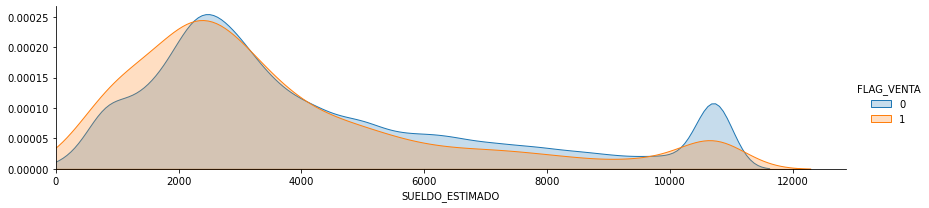

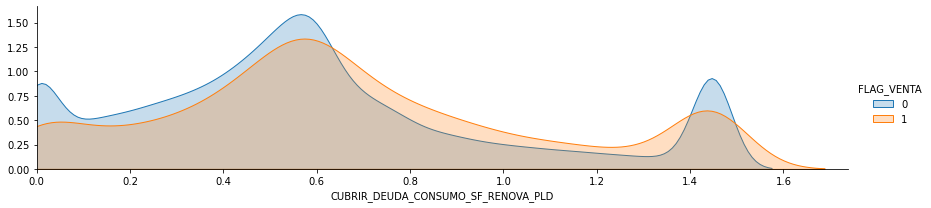

In [29]:
for cat in numerical_features:
    a = sns.FacetGrid(data[[cat,"FLAG_VENTA"]], hue = 'FLAG_VENTA', aspect=4)
    a.map(sns.kdeplot, cat, shade= True )
    a.set(xlim=(0 , data[cat].max()*1.2))
    a.add_legend()
    gc.collect()
    #plt.show()
    #print('Skew for train data:',Train_Balanceado.Renta.skew())
    del a
    gc.collect()

In [30]:
data[numerical_features].corr("pearson")

,LINEA_RENOVADO,PLAZO_RENOVADO,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,RESENCIA_OFERTA_PLD_RENOVADO,Ahorro_Sldo_Bco_T1,PConsumo_Sldo_Bco_T1,SDO_BCO_tot_sm_pasivo_Bco_6M,EDAD,ANTIGUEDAD_MES,SUELDO_ESTIMADO,CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD
LINEA_RENOVADO,1.000000,0.521622,0.023769,0.108928,0.092558,-0.109241,0.623374,-0.012372,0.247210,0.684451,0.327887,0.100091,0.177337,0.402597,-0.118681
PLAZO_RENOVADO,0.521622,1.000000,0.056481,0.059889,0.109069,-0.133113,0.359566,0.054550,0.064708,0.380667,0.123097,0.104118,0.147103,0.117190,0.031023
USO_LINEA_TOTAL_TC_T2,0.023769,0.056481,1.000000,0.502268,0.291877,0.017460,0.296060,-0.182264,-0.092514,0.052340,-0.057532,-0.110502,-0.053754,0.035696,0.462030
USO_TRIM_LINEA_BBVA,0.108928,0.059889,0.502268,1.000000,0.093297,-0.037027,0.242366,-0.147693,0.011437,0.128910,0.069958,-0.135156,-0.022134,0.135874,0.255337
NR_ENTIDADES_TOTAL_T2,0.092558,0.109069,0.291877,0.093297,1.000000,0.216529,0.344320,-0.057823,-0.013350,0.117989,0.022248,0.040330,0.050516,0.120426,0.519763
DIFF_NRO_ENTIDA_TOTALES_T2_T12,-0.109241,-0.133113,0.017460,-0.037027,0.216529,1.000000,0.025578,-0.127184,-0.038202,-0.061127,-0.064416,-0.050167,-0.084978,-0.041625,0.115172
SDO_CONSUMO_T2,0.623374,0.359566,0.296060,0.242366,0.344320,0.025578,1.000000,-0.165587,0.178759,0.710588,0.252028,0.072610,0.144157,0.383114,0.548792
RESENCIA_OFERTA_PLD_RENOVADO,-0.012372,0.054550,-0.182264,-0.147693,-0.057823,-0.127184,-0.165587,1.000000,0.045369,-0.164602,0.045898,0.085457,0.111113,0.050117,-0.208690
Ahorro_Sldo_Bco_T1,0.247210,0.064708,-0.092514,0.011437,-0.013350,-0.038202,0.178759,0.045369,1.000000,0.234789,0.576678,0.062968,0.155970,0.336011,-0.062257
PConsumo_Sldo_Bco_T1,0.684451,0.380667,0.052340,0.128910,0.117989,-0.061127,0.710588,-0.164602,0.234789,1.000000,0.270599,0.044299,0.108184,0.331472,0.182399



* Vemos que no hay ninguna muy variable correlacionada, con valor mayor a 0.8.

## 2.- Tratamiento a las variables

* inputacion de valores faltantes
* a los valores atipicos
* tratamiento a las variables categoricas

In [31]:
data["FLAG_VENTA"].value_counts(normalize=True)

0    0.960117
1    0.039883
Name: FLAG_VENTA, dtype: float64

In [32]:
data=data[~data["USO_TRIM_LINEA_BBVA"].isnull()].reset_index()
del data["index"]

Seleccionbado las filas no nulas de la variable "USO_TRIM_LINEA_BBVA"

In [33]:
list_var_num_null=["USO_LINEA_TOTAL_TC_T2","USO_TRIM_LINEA_BBVA","SDO_CONSUMO_T2","RESENCIA_OFERTA_PLD_RENOVADO","EDAD","SUELDO_ESTIMADO","ANTIGUEDAD_MES","CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"]
list_var_cat_null=["SEXO","EST_CIVIL","REGION"]
data[["USO_LINEA_TOTAL_TC_T2","USO_TRIM_LINEA_BBVA","SDO_CONSUMO_T2","RESENCIA_OFERTA_PLD_RENOVADO","EDAD","SEXO","EST_CIVIL","REGION","ANTIGUEDAD_MES","SUELDO_ESTIMADO","CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"]].isnull().sum()


USO_LINEA_TOTAL_TC_T2                    0
USO_TRIM_LINEA_BBVA                      0
SDO_CONSUMO_T2                        2219
RESENCIA_OFERTA_PLD_RENOVADO             0
EDAD                                     0
SEXO                                     0
EST_CIVIL                                0
REGION                                  15
ANTIGUEDAD_MES                           0
SUELDO_ESTIMADO                         14
CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD       0
dtype: int64

Vemos que las variables ["USO_LINEA_TOTAL_TC_T2","USO_TRIM_LINEA_BBVA","RESENCIA_OFERTA_PLD_RENOVADO","EDAD","SEXO","EST_CIVIL","REGION","SUELDO_ESTIMADO","CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"] tiene nullos.

In [34]:
for col in list_var_num_null:
    #print(col,data[col].median())
    data.loc[:,col]=data[col].fillna(data[col].median()) 
for col in list_var_cat_null:
    #print(col,data[col].mode()[0])
    data.loc[:,col]=data[col].fillna(data[col].mode()[0])     

Realizando imputación de las variables ["USO_LINEA_TOTAL_TC_T2","USO_TRIM_LINEA_BBVA","RESENCIA_OFERTA_PLD_RENOVADO","EDAD","SEXO","EST_CIVIL","REGION","SUELDO_ESTIMADO","CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"] con la mediana y moda

In [35]:
data[["USO_LINEA_TOTAL_TC_T2","USO_TRIM_LINEA_BBVA","SDO_CONSUMO_T2","RESENCIA_OFERTA_PLD_RENOVADO","ANTIGUEDAD_MES","EDAD","SEXO","EST_CIVIL","REGION","SUELDO_ESTIMADO","CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD"]].isnull().sum()

USO_LINEA_TOTAL_TC_T2                 0
USO_TRIM_LINEA_BBVA                   0
SDO_CONSUMO_T2                        0
RESENCIA_OFERTA_PLD_RENOVADO          0
ANTIGUEDAD_MES                        0
EDAD                                  0
SEXO                                  0
EST_CIVIL                             0
REGION                                0
SUELDO_ESTIMADO                       0
CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD    0
dtype: int64

## Creando variables dummy

In [36]:
for col in cat_features:
    print(" value unique",col,"is:",data[col].nunique())

 value unique SEXO is: 2
 value unique EST_CIVIL is: 7
 value unique REGION is: 14
 value unique FLAG_LIMA_PROVINCIA is: 2
 value unique MES is: 9


In [37]:
data.head()

,MES,CLIENTE,LINEA_RENOVADO,PLAZO_RENOVADO,FLAG_VENTA,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,...,PConsumo_Sldo_Bco_T1,SDO_BCO_tot_sm_pasivo_Bco_6M,EDAD,SEXO,EST_CIVIL,ANTIGUEDAD_MES,REGION,FLAG_LIMA_PROVINCIA,SUELDO_ESTIMADO,CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD
0,201506,1,3.576341,12,0,0.000000,0.000000,1,1,271.12,...,457.0,3754.333333,25.0,M,S,1.361728,LIMA NORTE,1,3531.0,0.071915
1,201506,2,3.291637,6,0,0.000000,0.000000,1,0,11200.00,...,11200.0,1581.333333,33.0,M,S,1.748188,LIMA ESTE,1,1322.0,1.447977
2,201506,3,3.892095,36,0,0.429507,0.172813,5,2,20156.45,...,4778.0,10241.000000,26.0,M,S,1.301030,LIMA MODERNA,1,4234.0,1.447977
3,201506,4,3.821514,12,0,0.000000,0.000000,1,1,20485.14,...,0.0,5797.333333,51.0,M,S,2.220108,NORTE,0,6647.0,1.447977
4,201506,6,4.118265,36,0,0.207272,0.000000,2,2,5047.05,...,4186.0,8725.833333,27.0,M,S,1.740363,LIMA NORTE,1,2523.0,0.384390


In [38]:
data=pd.get_dummies(data,columns=cat_features)

Creando variables dummies con la lista de variables categóricas

In [39]:
data.head()

,CLIENTE,LINEA_RENOVADO,PLAZO_RENOVADO,FLAG_VENTA,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,RESENCIA_OFERTA_PLD_RENOVADO,...,FLAG_LIMA_PROVINCIA_1,MES_201501,MES_201502,MES_201503,MES_201504,MES_201505,MES_201506,MES_201507,MES_201508,MES_201509
0,1,3.576341,12,0,0.000000,0.000000,1,1,271.12,21.0,...,1,0,0,0,0,0,1,0,0,0
1,2,3.291637,6,0,0.000000,0.000000,1,0,11200.00,9.0,...,1,0,0,0,0,0,1,0,0,0
2,3,3.892095,36,0,0.429507,0.172813,5,2,20156.45,0.0,...,1,0,0,0,0,0,1,0,0,0
3,4,3.821514,12,0,0.000000,0.000000,1,1,20485.14,20.0,...,0,0,0,0,0,0,1,0,0,0
4,6,4.118265,36,0,0.207272,0.000000,2,2,5047.05,11.0,...,1,0,0,0,0,0,1,0,0,0


## Escalando las variables

In [40]:
### Standardize Datasets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit_transform(data[numerical_features])
X_summit_scaler = scaler.transform(data[numerical_features].values)
X_scaler = pd.DataFrame(X_scaler, columns=data[numerical_features].columns)
X_summit_scaler = pd.DataFrame(X_summit_scaler, columns=data[numerical_features].columns)

* Escalando variables para que todos tenga un mismo intervalo.
* Sabemos que la regresión logística es sensible a los atípicos.

In [41]:
X_summit_scaler.isnull().sum()

LINEA_RENOVADO                        0
PLAZO_RENOVADO                        0
USO_LINEA_TOTAL_TC_T2                 0
USO_TRIM_LINEA_BBVA                   0
NR_ENTIDADES_TOTAL_T2                 0
DIFF_NRO_ENTIDA_TOTALES_T2_T12        0
SDO_CONSUMO_T2                        0
RESENCIA_OFERTA_PLD_RENOVADO          0
Ahorro_Sldo_Bco_T1                    0
PConsumo_Sldo_Bco_T1                  0
SDO_BCO_tot_sm_pasivo_Bco_6M          0
EDAD                                  0
ANTIGUEDAD_MES                        0
SUELDO_ESTIMADO                       0
CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD    0
dtype: int64

In [42]:
#data2=data.drop(numerical_features,axis=1)
#data2=pd.concat([data2,X_summit_scaler],axis=1)
#data2.head()
data2=data

Añadiendo las variables escaladas(X_summit_scaler) al dataset

## 3 y  4 .- Modelado : Preparando la data e Interpetración

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X=data2.drop(["FLAG_VENTA","CLIENTE"],axis=1)
y=data2["FLAG_VENTA"]

In [45]:
data["FLAG_VENTA"].mean()

0.04018196711719618

In [46]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

Dividiendo el dataset en train(70 %) y test(30 %)

In [47]:
#predictors= [var for var in data if var not in ["FLAG_VENTA","CLIENTE","var_max_sbs_qual_12m"]]
predictors= [var for var in data if var not in ["FLAG_VENTA","CLIENTE"]]

Lista de las variables que predecirán el target( Clientes Moroso  o no Moroso)

In [48]:
X_train[predictors].isnull().sum()

LINEA_RENOVADO                        0
PLAZO_RENOVADO                        0
USO_LINEA_TOTAL_TC_T2                 0
USO_TRIM_LINEA_BBVA                   0
NR_ENTIDADES_TOTAL_T2                 0
DIFF_NRO_ENTIDA_TOTALES_T2_T12        0
SDO_CONSUMO_T2                        0
RESENCIA_OFERTA_PLD_RENOVADO          0
Ahorro_Sldo_Bco_T1                    0
PConsumo_Sldo_Bco_T1                  0
SDO_BCO_tot_sm_pasivo_Bco_6M          0
EDAD                                  0
ANTIGUEDAD_MES                        0
SUELDO_ESTIMADO                       0
CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD    0
SEXO_F                                0
SEXO_M                                0
EST_CIVIL_C                           0
EST_CIVIL_D                           0
EST_CIVIL_S                           0
EST_CIVIL_U                           0
EST_CIVIL_V                           0
EST_CIVIL_X                           0
EST_CIVIL_Y                           0
REGION_CALLAO                         0


## Modelado: Regresión Logística

In [49]:

from sklearn.linear_model import LogisticRegression
logmodel_l1 = LogisticRegression(penalty='l1', solver='liblinear')
logmodel_l1.fit(X_train[predictors],y_train)


LogisticRegression(penalty='l1', solver='liblinear')

In [50]:
X_train.head(5)

,LINEA_RENOVADO,PLAZO_RENOVADO,USO_LINEA_TOTAL_TC_T2,USO_TRIM_LINEA_BBVA,NR_ENTIDADES_TOTAL_T2,DIFF_NRO_ENTIDA_TOTALES_T2_T12,SDO_CONSUMO_T2,RESENCIA_OFERTA_PLD_RENOVADO,Ahorro_Sldo_Bco_T1,PConsumo_Sldo_Bco_T1,...,FLAG_LIMA_PROVINCIA_1,MES_201501,MES_201502,MES_201503,MES_201504,MES_201505,MES_201506,MES_201507,MES_201508,MES_201509
34071,3.892095,36,0.299074,0.000000,2,1,2272.17,21.0,146.0,1419.0,...,1,0,0,0,1,0,0,0,0,0
15963,4.197087,48,0.115439,0.000000,4,1,31622.20,6.0,6068.0,47701.5,...,0,0,0,0,0,0,0,0,0,1
53971,4.223937,36,0.000000,0.000000,1,1,9676.23,20.0,12894.5,19586.0,...,0,0,1,0,0,0,0,0,0,0
27465,4.193125,36,0.000000,0.000000,1,0,8164.30,18.0,0.0,8250.0,...,0,0,0,0,0,0,1,0,0,0
31302,4.096249,30,0.478156,0.172813,3,1,14563.02,18.0,12.0,16044.0,...,1,0,0,0,0,1,0,0,0,0


In [51]:
y_train=y_train.astype(np.int16)

LINEA_RENOVADO                        0.764690
PLAZO_RENOVADO                       -0.003702
USO_LINEA_TOTAL_TC_T2                 0.926998
USO_TRIM_LINEA_BBVA                   2.369965
NR_ENTIDADES_TOTAL_T2                 0.036509
DIFF_NRO_ENTIDA_TOTALES_T2_T12        0.009176
SDO_CONSUMO_T2                       -0.000003
RESENCIA_OFERTA_PLD_RENOVADO         -0.036835
Ahorro_Sldo_Bco_T1                   -0.000026
PConsumo_Sldo_Bco_T1                  0.000008
SDO_BCO_tot_sm_pasivo_Bco_6M         -0.000009
EDAD                                  0.003105
ANTIGUEDAD_MES                       -0.175681
SUELDO_ESTIMADO                      -0.000079
CUBRIR_DEUDA_CONSUMO_SF_RENOVA_PLD    0.040076
SEXO_F                               -1.693736
SEXO_M                               -1.516827
EST_CIVIL_C                          -0.070871
EST_CIVIL_D                           0.000000
EST_CIVIL_S                           0.000000
EST_CIVIL_U                          -0.063619
EST_CIVIL_V  

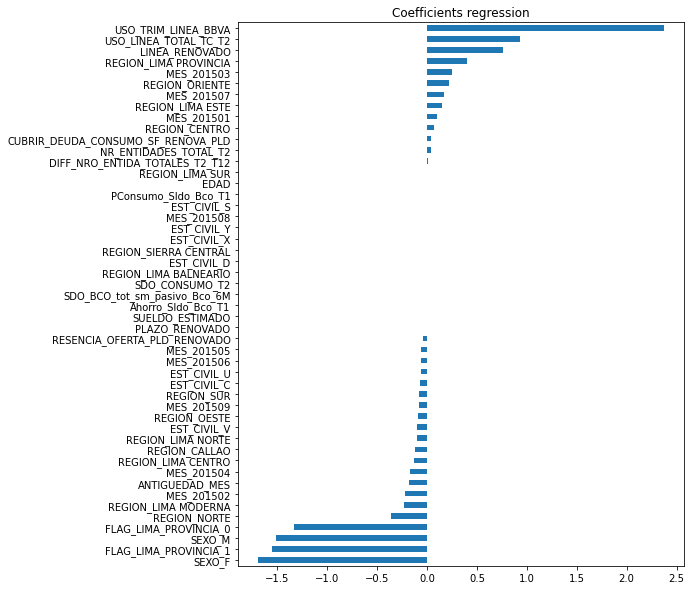

In [52]:
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

coef = pd.Series(logmodel_l1.coef_[0], index = predictors)
print(coef)

imp_coef = pd.concat([coef.sort_values()])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients regression")

var_impor = imp_coef.index
var_impor = list(var_impor)

* en el grafico podemos observar los coeficintes de la regresion logistica,lo cual para la variables LINEA_RENOVADO que tiene el mayor valor de coeficiente.

In [53]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

In [54]:
y_predict=logmodel_l1.predict_proba(X_train[predictors])[:,1]

In [55]:
len(y_train)

47854

In [56]:
from sklearn.metrics import classification_report,confusion_matrix

In [57]:
from sklearn.metrics import (precision_score, recall_score,f1_score,accuracy_score,precision_recall_curve)

In [58]:
scores=cross_val_score(logmodel_l1, X_train[predictors], y_train, scoring = 'accuracy', cv = 10, n_jobs = -1)
print( "media:" + str(scores.mean()) , "- desviación standar:" + str( scores.std()))

media:0.9598152788894463 - desviación standar:9.248903864214127e-05


Aplicando Cross Validation con cv=10 vemos que la media del accuracy es 0.9598152788894463    con desviación standar 0.00011320650265365915 

In [59]:
y_train.value_counts()

0    45931
1     1923
Name: FLAG_VENTA, dtype: int64

In [60]:
print(confusion_matrix(y_train,np.where(logmodel_l1.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

[[29401 16530]
 [  725  1198]]


Vemos que el modelo predice correctamente:
* 29401    clientes sin venta de 45931 .
* 1198 clientes con venta de 1923 .

In [95]:
print(classification_report(y_train,np.where(logmodel_l1.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.98      0.64      0.77     45931
           1       0.07      0.62      0.12      1923

    accuracy                           0.64     47854
   macro avg       0.52      0.63      0.45     47854
weighted avg       0.94      0.64      0.75     47854



Vemos que el accuaracy es 0.64 que indica que está clasificando correctamento ( ya con venta o sin venta)

In [96]:
y_test.value_counts()

0    19686
1      824
Name: FLAG_VENTA, dtype: int64

In [97]:
print(confusion_matrix(y_test,np.where(logmodel_l1.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

[[12739  6947]
 [  327   497]]


Vemos que el modelo predice correctamente:
* 12739  clientes sin venta de 19686 .
* 497    clientes con venta de 824 .

In [98]:
print(classification_report(y_test,np.where(logmodel_l1.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     19686
           1       0.07      0.60      0.12       824

    accuracy                           0.65     20510
   macro avg       0.52      0.63      0.45     20510
weighted avg       0.94      0.65      0.75     20510



* Vemos que el accuaracy es 0.65 que indica que está clasificando correctamente( ya con venta o sin venta) igual que el train.
* Entonces es un modelo estable en el train y test


## Modelado: Desicion Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train[predictors],y_train)

DecisionTreeClassifier()

In [67]:
dt_pred = dt_model.predict(X_test[predictors])

In [68]:
scores=cross_val_score(dt_model, X_train[predictors], y_train, scoring = 'accuracy', cv = 10, n_jobs = -1)
print( "media:" + str(scores.mean()) , "- desviación standar:" + str( scores.std()))

media:0.9177707708087984 - desviación standar:0.0026814338949398687


Aplicando Cross Validation con cv=10 vemos que la media del accuracy es 0.9177707708087984 con desviación standar 0.0026814338949398687

In [69]:
print(confusion_matrix(y_train,np.where(dt_model.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

[[45931     0]
 [    0  1923]]


* Vemos que el modelo sobre aprendió
* Clasificando correctamente los clientes "con venta" y "sin venta"


In [70]:
print(classification_report(y_train,np.where(dt_model.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45931
           1       1.00      1.00      1.00      1923

    accuracy                           1.00     47854
   macro avg       1.00      1.00      1.00     47854
weighted avg       1.00      1.00      1.00     47854



Todos los indicadores son 100 % ya que el modelos sobre aprendió

In [71]:
y_test.value_counts()

0    19686
1      824
Name: FLAG_VENTA, dtype: int64

In [72]:
print(confusion_matrix(y_test,np.where(dt_model.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

[[18719   967]
 [  766    58]]


Vemos que el modelo predice correctamente:

* 18719 Cientes "sin venta" de 19686 .
* 58    Clientes "con venta" de 824 .

In [99]:
print(classification_report(y_test,np.where(dt_model.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     19686
           1       0.06      0.07      0.06       824

    accuracy                           0.92     20510
   macro avg       0.51      0.51      0.51     20510
weighted avg       0.92      0.92      0.92     20510



* Vemos que el accuaracy es 0.92 diferente el train que es 1.0.
* Entonces es un modelo inestable en el test.

## Modelado: Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
rf= RandomForestClassifier()
rf.fit(X_train[predictors],y_train)

RandomForestClassifier()

In [102]:
rf_pre=rf.predict(X_test[predictors])

In [103]:
scores=cross_val_score(rf, X_train[predictors], y_train, scoring = 'accuracy', cv = 10, n_jobs = -1)
print( "media:" + str(scores.mean()) , "- desviación standar:" + str( scores.std()))

media:0.9598152788894463 - desviación standar:9.248903864214127e-05


Aplicando Cross Validation con cv=10 vemos que la media del accuracy es 0.9598152788894463   con desviación standar 0.00009.24890386421

In [104]:
print(confusion_matrix(y_train,np.where(rf.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

[[42469  3462]
 [    0  1923]]


In [105]:
y_train.value_counts()

0    45931
1     1923
Name: FLAG_VENTA, dtype: int64

Vemos que el modelo predice correctamente:

* 42469 clientes "sin venta" de 45931 .
* 1923  Clientes "con venta" de 1923 .

In [106]:
print(classification_report(y_train,np.where(rf.predict_proba(X_train[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     45931
           1       0.36      1.00      0.53      1923

    accuracy                           0.93     47854
   macro avg       0.68      0.96      0.74     47854
weighted avg       0.97      0.93      0.94     47854



Vemos que el accuaracy es 0.93

In [107]:
print(confusion_matrix(y_test,np.where(rf.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

[[12625  7061]
 [  370   454]]


In [108]:
y_test.value_counts()

0    19686
1      824
Name: FLAG_VENTA, dtype: int64

Vemos que el modelo predice correctamente:

* 12625      cientes sin venta de 19686
* 454 clientes con venta de 824

In [109]:
print(classification_report(y_test,np.where(rf.predict_proba(X_test[predictors])[:,1]<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.97      0.64      0.77     19686
           1       0.06      0.55      0.11       824

    accuracy                           0.64     20510
   macro avg       0.52      0.60      0.44     20510
weighted avg       0.93      0.64      0.75     20510



* Vemos que el accuaracy es 0.64 en comparación del train 0.93
* Entonces el modelo es inestable en el test

# Conclusión con los modelos con parametros de default

## Modelado: El mejor Modelo "Regresión Logística"
* Es el modelo más estable en el train y test.
* Es el modelo con mayor accuracy utilizando Cross Validatión.
* Es el segundo mejor modelo que predice la cantidad de clientes morosos con 602.
* El modelo de regresion logistca es la más facil de interpretar y se usa mucho en la banca.


## Conclusion:
* 1. Mediante EDA ,encontramos variables que numericas que tenian valores missing.
* 2. Las variables mas importante es LINEA_RENOVADO.
* 3. No se encontro variables numericas que estaban altamente correlacionadas
* 4. Se identicó que el mejor modelo es la regresión logística por su estabilidad, interpetración e predicción de los clientes morosos.
* 5. El cross validation ayudó identificar la estabilidad del modelo con diferente muestras.

## Recomendaciones:
* 1. Para mejorar la precision del modelo podriamos crear mas features.
* 2. Se podría usar cross validation para el entranamiento del modelo.
* 3. Filtrar las vairables que no aportan al modelo
* 4. Usar otros modelos más avanzandos.

# Aplicando modelos 2: Ligtbm y catbossting con parámetros, Croos Validation emsamble y punto de corte óptimo

In [110]:
train,test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
train["FLAG_VENTA"]=y_train
test["FLAG_VENTA"]=y_test

<ipython-input-110-85d60876266c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["FLAG_VENTA"]=y_train
<ipython-input-110-85d60876266c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["FLAG_VENTA"]=y_test


In [111]:
#train=df[df["MES"].isin(["1","2","3","4","5"])]
#test=df[df["MES"].isin(["5","6","7","8","9"])]
#y_test=df[df["MES"].isin(["5","6","7","8","9"])]["FLAG_VENTA"]

In [112]:
features=[ x for x in train.columns if x not in ['FLAG_VENTA','CLIENTE']]

#categorical=['TP_VIVI', 'TP_PERSONA', 'TIPO_NEGOCIO']

#cat_ind=[features.index(x) for x in categorical if x in features]

target='FLAG_VENTA'

In [113]:
train=train.reset_index()
test=test.reset_index()

In [114]:
kf_previo=StratifiedKFold(n_splits=5,random_state=256,shuffle=True)

i=1

r=[]

importancias=pd.DataFrame()

importancias['variable']=features

oof = np.zeros(len(train))

for train_index,test_index in kf_previo.split(train,train[target]):

    lgb_train = lgb.Dataset(train.loc[train_index,features].values,train.loc[train_index,target].values.ravel())
    lgb_eval = lgb.Dataset(train.loc[test_index,features].values,train.loc[test_index,target].values.ravel(), reference=lgb_train)

    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': { 'auc'},
        "max_depth":4,
        "num_leaves":10,
        'learning_rate': 0.1,
    "min_child_samples": 100,
        'feature_fraction': 0.5,
     "bagging_freq":1,
        'bagging_fraction': 0.9,
        "lambda_l1":1,
        "lambda_l2":1,
        #"scale_pos_weight":30,

        'verbose': 1    
    }




    lgbm3 = lgb.train(params,lgb_train,num_boost_round=13100,valid_sets=lgb_eval,early_stopping_rounds=50,verbose_eval=25)#,categorical_feature=cat_ind)
    test["TARGET_FOLD"+str(i)]=lgbm3.predict(test[features].values, num_iteration=lgbm3.best_iteration)
    
    oof[test_index] = lgbm3.predict(train.iloc[test_index][features], num_iteration=lgbm3.best_iteration)
    
    importancias['gain_'+str(i)]=lgbm3.feature_importance(importance_type="gain")

    
    print ("Fold_"+str(i))
    a= (roc_auc_score(train.loc[test_index,target],lgbm3.predict(train.loc[test_index,features].values, num_iteration=lgbm3.best_iteration)))
    r.append(a)
    print (a)
    print ("")
    
    i=i+1

print ("mean: "+str(np.mean(np.array(r))))
print ("std: "+str(np.std(np.array(r))))

Training until validation scores don't improve for 50 rounds
[25]	valid_0's auc: 0.669195
[50]	valid_0's auc: 0.673001
[75]	valid_0's auc: 0.674379
[100]	valid_0's auc: 0.673577
[125]	valid_0's auc: 0.672818
Early stopping, best iteration is:
[83]	valid_0's auc: 0.674883
Fold_1
0.6748825332897936

Training until validation scores don't improve for 50 rounds
[25]	valid_0's auc: 0.679447
[50]	valid_0's auc: 0.683176
[75]	valid_0's auc: 0.684575
[100]	valid_0's auc: 0.684215
Early stopping, best iteration is:
[65]	valid_0's auc: 0.685808
Fold_2
0.6858078781658141

Training until validation scores don't improve for 50 rounds
[25]	valid_0's auc: 0.67087
[50]	valid_0's auc: 0.673549
[75]	valid_0's auc: 0.678163
[100]	valid_0's auc: 0.675354
[125]	valid_0's auc: 0.674848
Early stopping, best iteration is:
[77]	valid_0's auc: 0.678724
Fold_3
0.6787239757847203

Training until validation scores don't improve for 50 rounds
[25]	valid_0's auc: 0.682387
[50]	valid_0's auc: 0.68369
[75]	valid_0's a

In [115]:
w=[x for x in test.columns if 'FOLD' in x]

test['FLAG_VENTA_PRED_lgb']=test[w].mean(axis=1)

In [116]:
y_train.values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [139]:
print(confusion_matrix(y_train,np.where(oof<0.040182,0,1)))

[[29702 16229]
 [  763  1160]]


In [141]:
print(classification_report(y_train.values,np.where(oof<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     45931
           1       0.07      0.60      0.12      1923

    accuracy                           0.64     47854
   macro avg       0.52      0.62      0.45     47854
weighted avg       0.94      0.64      0.75     47854



In [172]:
print(confusion_matrix(y_test.values,np.where(test["FLAG_VENTA_PRED_lgb"].values<0.0375,0,1)))

[[11892  7794]
 [  261   563]]


In [120]:
print(classification_report(y_test.values,np.where(test["FLAG_VENTA_PRED_lgb"].values<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     19686
           1       0.07      0.63      0.13       824

    accuracy                           0.65     20510
   macro avg       0.52      0.64      0.45     20510
weighted avg       0.94      0.65      0.75     20510



In [121]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

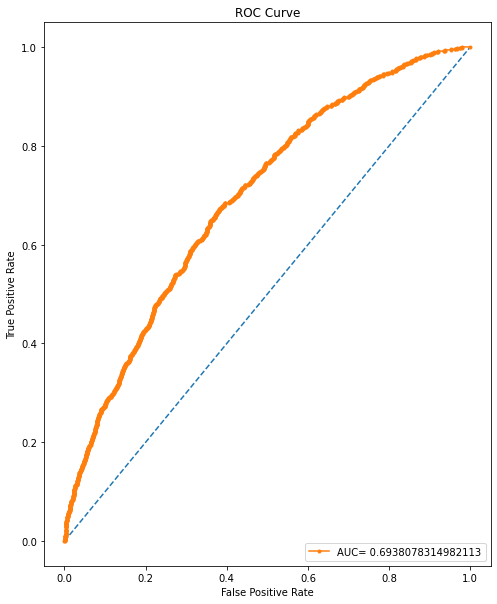

In [122]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, test["FLAG_VENTA_PRED_lgb"])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label="AUC= {}".format(roc_auc_score(y_test, test["FLAG_VENTA_PRED_lgb"])))
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

In [173]:

w=[x for x in importancias.columns if 'gain_' in x]

importancias['gain-avg']=importancias[w].mean(axis=1)

importancias=importancias.sort_values('gain-avg',ascending=False).reset_index(drop=True)

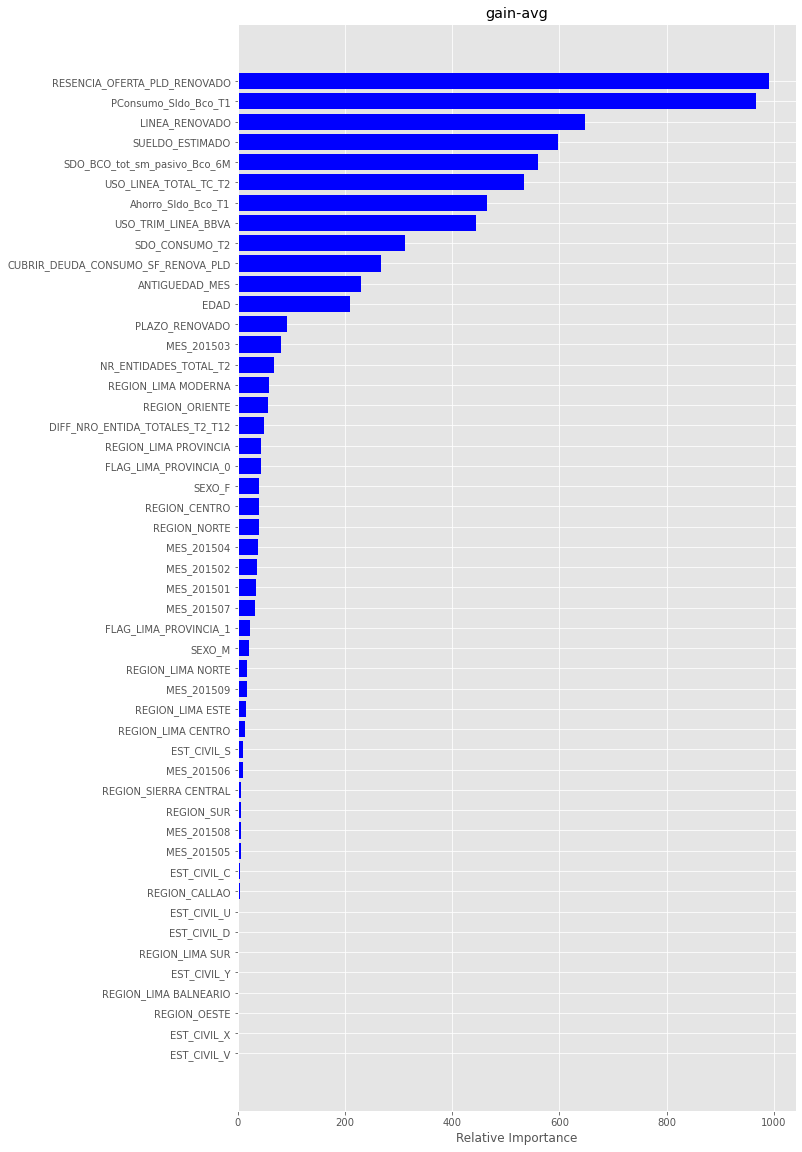

In [192]:
features = importancias['variable']
importances = importancias["gain-avg"]
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('gain-avg')

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')
plt.show()

# Catboosting

In [123]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

In [124]:
#pip install catboost

In [125]:
kf_previo=StratifiedKFold(n_splits=5,random_state=18,shuffle=True)

i=1

r=[]

importancias_c=pd.DataFrame()

importancias_c['variable']=features

for train_index,test_index in kf_previo.split(train,train[target]):

    model=CatBoostClassifier(iterations=30000, depth=4, learning_rate=0.1,l2_leaf_reg=5, rsm=0.7,bootstrap_type="Bernoulli",subsample=0.9,eval_metric='AUC',use_best_model=True,early_stopping_rounds=50,verbose=25)

    model.fit(train.loc[train_index,features], train.loc[train_index,target], eval_set=(train.loc[test_index,features] ,train.loc[test_index,target]),plot=False)
    
    
    importancias_c['gain_'+str(i)]=model.get_feature_importance()
    
    print ("Fold_"+str(i))
    a= (roc_auc_score(train.loc[test_index,target],model.predict_proba(train.loc[test_index,features].values)[:,1]))
    
    train.loc[test_index,"probabilidad"]=model.predict_proba(train.loc[test_index,features].values)[:,1]
    
    test["TARGET_FOLD"+str(i)]=model.predict_proba(test[features].values)[:,1]

    
    r.append(a)
    print (a)
    print ("")
    gc.collect()
    i=i+1

print ("mean: "+str(np.mean(np.array(r))))
print ("std: "+str(np.std(np.array(r))))

0:	test: 0.5272807	best: 0.5272807 (0)	total: 99.4ms	remaining: 49m 41s
25:	test: 0.6470450	best: 0.6470450 (25)	total: 466ms	remaining: 8m 57s
50:	test: 0.6597485	best: 0.6597485 (50)	total: 858ms	remaining: 8m 23s
75:	test: 0.6646150	best: 0.6646150 (75)	total: 1.31s	remaining: 8m 34s
100:	test: 0.6678119	best: 0.6678617 (98)	total: 1.66s	remaining: 8m 11s
125:	test: 0.6689517	best: 0.6694840 (118)	total: 2.01s	remaining: 7m 57s
150:	test: 0.6681894	best: 0.6694840 (118)	total: 2.36s	remaining: 7m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694839969
bestIteration = 118

Shrink model to first 119 iterations.
Fold_1
0.6694839968615073

0:	test: 0.5207066	best: 0.5207066 (0)	total: 12.1ms	remaining: 6m 2s
25:	test: 0.6858813	best: 0.6858813 (25)	total: 369ms	remaining: 7m 5s
50:	test: 0.7001634	best: 0.7001634 (50)	total: 720ms	remaining: 7m 2s
75:	test: 0.7015436	best: 0.7023432 (73)	total: 1.06s	remaining: 6m 56s
100:	test: 0.7024953	best: 0.7029234 (86)	

In [126]:
w=[x for x in test.columns if 'FOLD' in x]

test['FLAG_VENTA_PRED_cat']=test[w].mean(axis=1)

In [127]:
print(confusion_matrix(y_train,np.where(train["probabilidad"].values<0.040182,0,1)))

[[30036 15895]
 [  741  1182]]


In [128]:
print(classification_report(y_train.values,np.where(train["probabilidad"].values<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     45931
           1       0.07      0.61      0.12      1923

    accuracy                           0.65     47854
   macro avg       0.52      0.63      0.45     47854
weighted avg       0.94      0.65      0.76     47854



In [129]:
print(confusion_matrix(y_test,np.where(test["FLAG_VENTA_PRED_cat"].values<0.040182,0,1)))

[[12943  6743]
 [  312   512]]


In [193]:
importancias_c

,variable,gain_1,gain_2,gain_3,gain_4,gain_5
0,LINEA_RENOVADO,6.580593,7.704188e+00,7.897193,7.679984,9.315831
1,PLAZO_RENOVADO,2.651552,1.833236e+00,1.816481,2.993329,1.003260
2,USO_LINEA_TOTAL_TC_T2,5.586244,6.701645e+00,5.099295,6.616302,4.418070
3,USO_TRIM_LINEA_BBVA,5.932537,4.285056e+00,4.832781,4.483389,5.767303
4,NR_ENTIDADES_TOTAL_T2,1.313113,1.133250e+00,1.572962,1.283649,0.505985
5,DIFF_NRO_ENTIDA_TOTALES_T2_T12,1.445204,1.126036e+00,1.294170,1.337448,0.613795
6,SDO_CONSUMO_T2,3.086396,2.216104e+00,3.656494,2.906805,2.986900
7,RESENCIA_OFERTA_PLD_RENOVADO,11.828742,1.083738e+01,12.006511,11.545202,14.947867
8,Ahorro_Sldo_Bco_T1,5.480918,6.750216e+00,6.524399,4.838233,7.315153
9,PConsumo_Sldo_Bco_T1,19.719766,1.939523e+01,15.982391,20.081587,19.556560


In [197]:
w=[x for x in importancias_c.columns if 'gain_' in x]

importancias_c['gain-avg']=importancias_c[w].mean(axis=1)

importancias_c=importancias_c.sort_values('gain-avg',ascending=False).reset_index(drop=True)

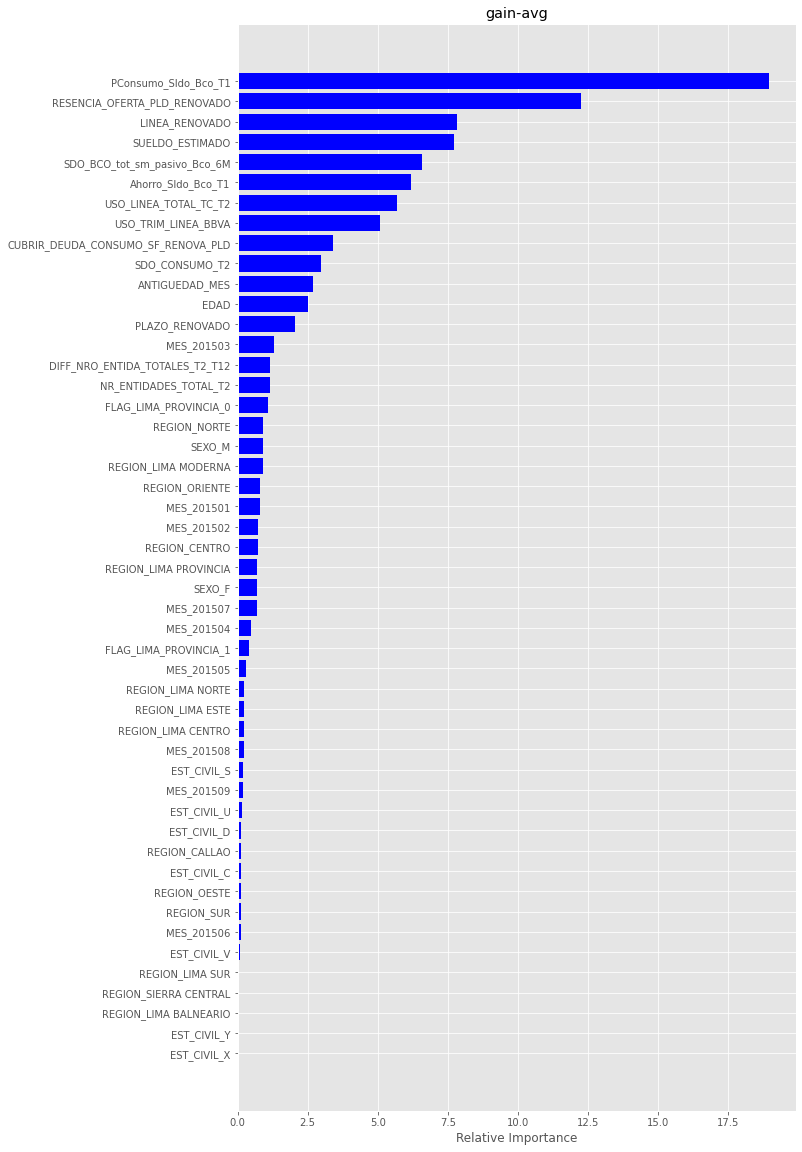

In [199]:
features = importancias_c['variable']
importances = importancias_c["gain-avg"]
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('gain-avg')

plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')
plt.show()

## Emsamble

In [153]:
y_train.value_counts(normalize=True)


0    0.959824
1    0.040176
Name: FLAG_VENTA, dtype: float64

In [150]:
print(confusion_matrix(y_test,np.where((pd.DataFrame(logmodel_l1.predict_proba(X_test[predictors])[:,1])[0]*0.4+ test["FLAG_VENTA_PRED_lgb"]*0.3+ test["FLAG_VENTA_PRED_cat"]*0.4)<0.040182,0,1)))

[[11643  8043]
 [  261   563]]


In [148]:
print(classification_report(y_test.values,np.where((pd.DataFrame(logmodel_l1.predict_proba(X_test[predictors])[:,1])[0]*0.4+ test["FLAG_VENTA_PRED_lgb"]*0.3+ test["FLAG_VENTA_PRED_cat"]*0.4)<0.040182,0,1)))

              precision    recall  f1-score   support

           0       0.98      0.59      0.74     19686
           1       0.07      0.68      0.12       824

    accuracy                           0.60     20510
   macro avg       0.52      0.64      0.43     20510
weighted avg       0.94      0.60      0.71     20510



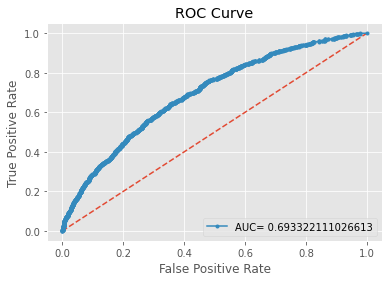

In [145]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test,(pd.DataFrame(logmodel_l1.predict_proba(X_test[predictors])[:,1])[0]*0.3+test["FLAG_VENTA_PRED_lgb"]*0.4+test["FLAG_VENTA_PRED_cat"]*0.3) )
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label="AUC= {}".format(roc_auc_score(y_test, (pd.DataFrame(logmodel_l1.predict_proba(X_test[predictors])[:,1])[0]*0.4+test["FLAG_VENTA_PRED_lgb"]*0.3+test["FLAG_VENTA_PRED_cat"]*0.4) )))
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")